In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import efficientnet_b0
import cv2
import numpy as np


In [2]:
classes = ['BF', 'BFI', 'BL', 'BLI', 'N', 'NI', 'TF']

In [3]:

# Parameters for Canny edge detection
threshold1 = 100
threshold2 = 200

# Parameters for noise injection
mean = 0  # Mean of Gaussian noise
std_dev = 10  # Standard deviation of Gaussian noise

# Function to add Gaussian noise
def add_gaussian_noise(image, mean, std_dev):
    noise = np.random.normal(mean, std_dev, image.shape).astype('float32')
    noisy_image = np.clip(image + noise, 0, 255)  # Ensure pixel values stay in range
    return noisy_image

# Function to apply Canny edge detection on a batch
def apply_canny_filter_batch(images, labels):
    processed_images = []
    for image in images:
        # Convert Tensor to NumPy array
        image_np = image.permute(1, 2, 0).cpu().numpy().astype('uint8')  # [C, H, W] -> [H, W, C]

        # Inject noise
        noisy_image_np = add_gaussian_noise(image_np, mean, std_dev)

        # Apply Canny edge detection
        edges = cv2.Canny(noisy_image_np.astype('uint8'), threshold1, threshold2)
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        processed_images.append(edges_rgb)

    # Convert back to Tensor
    processed_images = torch.tensor(np.array(processed_images), dtype=torch.float32).permute(0, 3, 1, 2)  # [N, H, W, C] -> [N, C, H, W]
    return processed_images, labels

# Define a wrapper around the dataset
class CannyEdgeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        images, labels = self.dataset[idx]
        # Apply Canny filter with noise injection
        processed_images, labels = apply_canny_filter_batch(images.unsqueeze(0), labels)
        return processed_images.squeeze(0), labels

In [4]:
class MCTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = classes
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        # Valid image extensions
        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

        # Populate image paths and labels
        for class_name, label in self.class_to_idx.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):  # Ensure it's a directory
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.splitext(img_path)[1].lower() in valid_extensions:
                        self.image_paths.append(img_path)
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization used for pre-trained models
])

In [6]:
# Define the root directory for your dataset
root_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# Initialize the dataset and dataloader
dataset = MCTDataset(root_dir=root_dir, transform=transform)

In [7]:
# Define split ratios
train_ratio = 0.8
test_ratio = 0.2

# Calculate split sizes
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
# Wrap the datasets
train_canny_dataset = CannyEdgeDataset(train_dataset)
test_canny_dataset = CannyEdgeDataset(test_dataset)

# Create DataLoaders for the wrapped datasets
train_loader = DataLoader(train_canny_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_canny_dataset, batch_size=32, shuffle=False, num_workers=0)

In [9]:
# # Create DataLoaders for each split
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.model.classifier = nn.Identity()  # Remove the classifier layer

    def forward(self, x):
        return self.model(x)

class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.model = models.vit_b_16(pretrained=True)
        self.model.heads = nn.Identity()  # Remove the final dense layer

    def forward(self, x):
        return self.model(x)


In [12]:
# Instantiate models
cnn_model = EfficientNet().to(device)
vit_model = VisionTransformer().to(device)

# Define training functions
def train_model(model, dataloader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent

In [13]:
# Freeze both models
for param in cnn_model.parameters():
    param.requires_grad = False
for param in vit_model.parameters():
    param.requires_grad = False

In [14]:
class ParallelModel(nn.Module):
    def __init__(self, cnn, vit, num_classes):
        super(ParallelModel, self).__init__()
        self.cnn = cnn  # CNN-based feature extractor (EfficientNet or ResNet)
        self.vit = vit  # Vision Transformer-based feature extractor
        self.fc = nn.Sequential(
            nn.Linear(2048, 256),  # Adjusted input size to match concatenated features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_features = self.cnn(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((cnn_features, vit_features), dim=1)  # Concatenate along feature dimension
        return self.fc(combined_features)

In [15]:
# #interleaving concatenation
# class ParallelModel(nn.Module):
#     def __init__(self, cnn, vit, num_classes):
#         super(ParallelModel, self).__init__()
#         self.cnn = cnn  # CNN-based feature extractor (EfficientNet or ResNet)
#         self.vit = vit  # Vision Transformer-based feature extractor
#         self.fc = nn.Sequential(
#             nn.Linear(2048, 256),  # Adjusted input size to match concatenated features
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
    
#     def forward(self, x):
#         cnn_features = self.cnn(x)
#         vit_features = self.vit(x)
        
#         # Ensure both features have the same shape for interleaving
#         if cnn_features.shape != vit_features.shape:
#             raise ValueError("CNN and ViT features must have the same shape for interleaving concatenation.")
        
#         # Perform interleaving concatenation
#         combined_features = torch.stack((cnn_features, vit_features), dim=2)
#         combined_features = combined_features.view(combined_features.size(0), -1)
        
#         return self.fc(combined_features)


In [16]:
parallel_model = ParallelModel(cnn_model, vit_model, num_classes=len(classes)).to(device)

In [17]:
def train_parallel_model(model, train_dataloader, validation_dataloader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in validation_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate average validation loss and accuracy
        val_loss /= len(validation_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [26]:
# Train the model and get the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_parallel_model(parallel_model, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Train Loss: 0.7890, Train Accuracy: 61.88%, Validation Loss: 0.8162, Validation Accuracy: 62.50%
Epoch 2/10, Train Loss: 0.8510, Train Accuracy: 60.62%, Validation Loss: 0.8059, Validation Accuracy: 55.00%
Epoch 3/10, Train Loss: 0.7496, Train Accuracy: 63.75%, Validation Loss: 0.8726, Validation Accuracy: 62.50%
Epoch 4/10, Train Loss: 0.7728, Train Accuracy: 62.50%, Validation Loss: 0.8370, Validation Accuracy: 60.00%
Epoch 5/10, Train Loss: 0.6722, Train Accuracy: 70.62%, Validation Loss: 0.8054, Validation Accuracy: 65.00%
Epoch 6/10, Train Loss: 0.6798, Train Accuracy: 68.75%, Validation Loss: 0.7079, Validation Accuracy: 75.00%
Epoch 7/10, Train Loss: 0.6817, Train Accuracy: 73.12%, Validation Loss: 0.6911, Validation Accuracy: 77.50%
Epoch 8/10, Train Loss: 0.6330, Train Accuracy: 73.75%, Validation Loss: 0.6313, Validation Accuracy: 77.50%
Epoch 9/10, Train Loss: 0.5825, Train Accuracy: 76.88%, Validation Loss: 0.6290, Validation Accuracy: 87.50%
Epoch 10/10, Train 

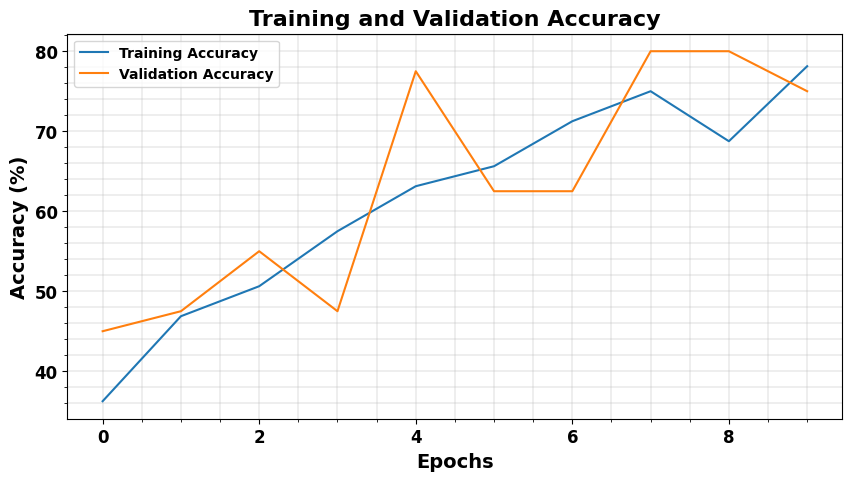

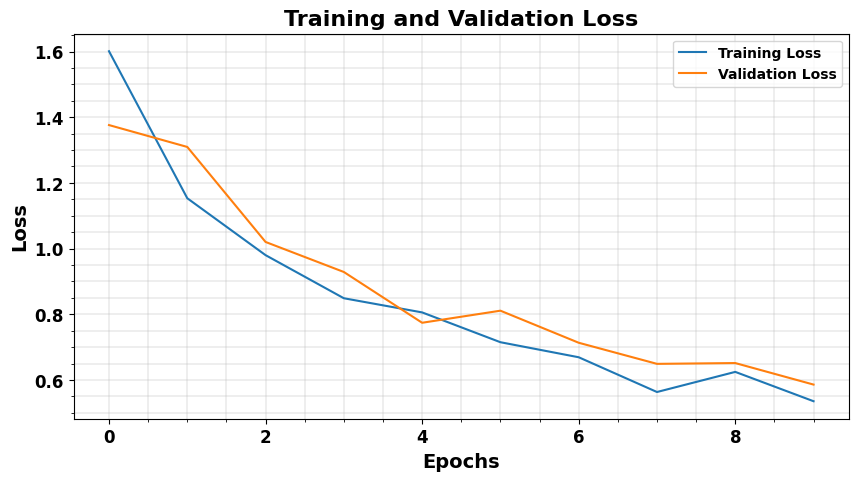

In [19]:

# Plotting the accuracy curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Comparison_model_training_val_accuracy.png", dpi=400)
plt.show()

# Plotting the loss curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Comparison_model_training_val_loss.png", dpi=400)
plt.show()

In [20]:
# Specify the file path to save the model
model_save_path = "parallel_model.pth"

# torch.save(parallel_model.state_dict(), model_save_path)

In [21]:
# Initialize the model structure first
parallel_model = ParallelModel(cnn_model, vit_model, num_classes=len(classes)).to(device)  # Replace with the correct model initialization if necessary

# Load the saved state_dict
parallel_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, but recommended for inference)
parallel_model.eval()

C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_29160\1690553310.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parallel_model.load_state_dict(torch.load(model_save

ParallelModel(
  (cnn): EfficientNet(
    (model): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


In [23]:

def evaluate_model(model, name, dataloader, num_classes):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Calculate and print classification report for per-class metrics
    report = classification_report(all_labels, all_predictions, target_names=classes, output_dict=True)

    # Extract overall metrics
    overall_accuracy = report['accuracy'] * 100
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # Print overall metrics
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.2f}")
    print(f"Weighted Recall: {recall:.2f}")
    print(f"Weighted F1 Score: {f1:.2f}")

    # Print per-class metrics
    print("\nPer-Class Metrics:")
    for class_name, metrics in report.items():
        if class_name in classes:
            print(f"\nClass '{class_name}':")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1 Score: {metrics['f1-score']:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False, 
                annot_kws={"size": 20, "fontweight": "bold"})
    plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=16, fontweight='bold')
    plt.setp(plt.gca().get_xticklabels(), fontweight='bold')
    plt.setp(plt.gca().get_yticklabels(), fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f"{name} confusion_matrix.png", dpi=1000)
    plt.show()

    # Calculate ROC Curve
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))  # Binarize labels
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probabilities)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.savefig(f"{name}_ROC_curve.png", dpi=1000)
    plt.show()


In [24]:
name = "Comparison_model"
evaluate_model(parallel_model, name, test_loader, len(classes))

ValueError: Number of classes, 5, does not match size of target_names, 7. Try specifying the labels parameter

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
# Set the model to evaluation mode
parallel_model.eval()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parallel_model.to(device)

# Function to extract features from the model
def get_features(model, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            output = model(data)  # Assumes output is already the desired features
            features.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels using the test DataLoader
features, labels_val = get_features(parallel_model, test_loader)

# Reshape features for t-SNE
features_val = features.reshape(features.shape[0], -1)

# Apply t-SNE to the features (2D version)
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_val)

# Plot the t-SNE results for 7 classes
plt.figure(figsize=(12, 10))

# Define class names, markers, and colors for 7 classes
class_names = ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
markers = ['o', 's', '^', 'v', 'D', '*', 'X']  # Different markers for each class
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Loop over each class and plot with specific markers and colors
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (labels_val == class_idx)  # Mask for the current class
    plt.scatter(features_tsne[class_mask, 0], features_tsne[class_mask, 1], 
                marker=marker, color=color, label=class_name, alpha=0.7)

# Add legend
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')

# Add title and labels
plt.title('t-SNE of Hybrid Model Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')

# Make the axis tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure
plt.savefig('tsne_2d_hybrid_model_7_classes.png', dpi=1000)

# Show the plot
plt.show()


Comparison model("Bearing Fault Diagnosis Method Based on CWT-ResNet18")

In [26]:
import torch.nn as nn
import torchvision.models as models


In [33]:
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [34]:
class ResNet18Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Model, self).__init__()
        # Load pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=True)
        # Replace the fully connected layer to match the number of classes
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512, num_classes)  # Final output layer for classification
        )
    
    def forward(self, x):
        return self.resnet18(x)

In [ ]:
ResNet18_model = ResNet18Model(num_classes=len(classes)).to(device)

In [36]:
def train_model(model, train_dataloader, validation_dataloader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in validation_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate average validation loss and accuracy
        val_loss /= len(validation_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
# Train the model and get the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_model(ResNet18_model, train_loader, test_loader, num_epochs=10)

In [ ]:

# Plotting the accuracy curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Proposed_model_training_val_accuracy.png", dpi=400)
plt.show()

# Plotting the loss curves with customized formatting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Adding labels, title, and legend with larger and bold font
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})

# Make tick labels bold and increase font size
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding a grid with both major and minor grid lines
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()
plt.savefig("Proposed_model_training_val_loss.png", dpi=400)
plt.show()

In [37]:
# Specify the file path to save the model
model_save_path = "ResNet18_model.pth"

# torch.save(ResNet18_model.state_dict(), model_save_path)

In [ ]:
# Initialize the model structure first
ResNet18_model = ResNet18Model(num_classes=len(classes)).to(device)  # Replace with the correct model initialization if necessary

# Load the saved state_dict
ResNet18_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, but recommended for inference)
ResNet18_model.eval()

In [ ]:
name = "Proposed model"
evaluate_model(ResNet18_model, name, test_loader, len(classes))

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
# Set the model to evaluation mode
parallel_model.eval()


# Function to extract features from the model
def get_features(model, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            output = model(data)  # Assumes output is already the desired features
            features.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels using the test DataLoader
features, labels_val = get_features(ResNet18_model, test_loader)

# Reshape features for t-SNE
features_val = features.reshape(features.shape[0], -1)

# Apply t-SNE to the features (2D version)
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_val)

# Plot the t-SNE results for 7 classes
plt.figure(figsize=(12, 10))

# Define class names, markers, and colors for 7 classes
class_names = ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
markers = ['o', 's', '^', 'v', 'D', '*', 'X']  # Different markers for each class
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Loop over each class and plot with specific markers and colors
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (labels_val == class_idx)  # Mask for the current class
    plt.scatter(features_tsne[class_mask, 0], features_tsne[class_mask, 1], 
                marker=marker, color=color, label=class_name, alpha=0.7)

# Add legend
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')

# Add title and labels
plt.title('t-SNE of Hybrid Model Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')

# Make the axis tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure
plt.savefig('tsne_2d_ResNet18.png', dpi=1000)

# Show the plot
plt.show()